In [1]:
pip install datareader

  Obtaining dependency information for argparse from https://files.pythonhosted.org/packages/f2/94/3af39d34be01a24a6e65433d19e107099374224905f1e0cc6bbe1fd22a2f/argparse-1.4.0-py2.py3-none-any.whl.metadata
Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install numpy-financial

In [3]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pandas_datareader import data as pdr
import seaborn as sns
from scipy.optimize import minimize
import threading
import time


## Group Assignment
### Team Number: 18
### Team Member Names: Alfred Jade Jenna
### Team Strategy Chosen: SAFE

---
## Filtering
We must filter through ``Tickers.csv`` file as not all stocks will be useful for our simulation. This data cleaning ensures that we refine the historical stock data to simulate portfolios that will be most realistic and to remove runtime errors that could occur due to lack of sufficient data.

### We must remove tickers that:
* Are not listed in USD or CAD
* Traded below average monthly volume of 150,000 shares
* Insufficient market data for January 1 2023 to October 1 2023
* Drop months with less than 18 trading days
* Insufficient data

In [9]:
filtered_volume_list = [] # Define empty list
def read_ticker_csv(csv):
    # Load CSV into pandas DF
    ticker_df = pd.read_csv(csv)
    ticker_df.columns = ['Tickers'] # Name column
    ticker_df = ticker_df.drop_duplicates() # Dropping duplicates
    tick_list = ticker_df['Tickers'].tolist() # Creating list of ticker
    filtered_list = [] # Defining empty list

    # Function that takes in a list of ticker strings, creating a list with elements as valid tickers
    # Valid tickers must be listed in USD or CAD. The resulting list is defined as filtered_list
    def filter_valid(tickers):
        for ticker in tickers:
            try:
                temp_tick = yf.Ticker(ticker)
                if temp_tick.fast_info['currency'] == 'USD' or temp_tick.fast_info['currency'] == 'CAD':
                    filtered_list.append(ticker)
                else:
                    print(f'{ticker} is not listed in USD or CAD, therefore has been removed')
            except KeyError as error:
                    print(f'Stock {ticker} not found, Dropped. Error: {error}')

    filter_valid(tick_list)

    print('\n\nNow making sure each stock meets the volume and trading day requirements.\n')


    # Function to filter out the months of a stock history that have less than 18 trading days
    def filter_months(stock_history):
        # Extract the month from the 'Date' column
        stock_history['Month'] = stock_history.index.to_period('M')
        # Count the number of trading days for each month
        trading_days = stock_history.groupby('Month').size()
        # Filter out months with fewer than 18 trading days
        invalid_months = trading_days[trading_days < 18].index
        # Print message for each removed month
        for invalid_month in invalid_months:
            print(f'Data for month {invalid_month} has been removed as it has less than 18 trading days.')
        # Filter the stock history based on valid months
        filtered_stock_history = stock_history[~stock_history['Month'].isin(invalid_months)]
        # Drop the 'Month' column as it's no longer needed
        filtered_stock_history = filtered_stock_history.drop(columns='Month')
        return filtered_stock_history

    # Checking to make sure each stock has a valid closing price on the Nov 24th 2023
    def has_closing_price(ticker):
        # Setting start and end date variables for the purpose of checking
        start_x = pd.to_datetime('2023-11-01')
        end_x = (datetime.now()+timedelta(days=1)).strftime('%Y-%m-%d')
        # Obtain closing history for ticker
        ticker_hist = (yf.download(ticker, start=start_x, end=end_x)).Close
        # If date is in the index for closing history
        if '2023-11-24' in ticker_hist.index.strftime('%Y-%m-%d').tolist():
            return False # Returns false since we are using this as a case when the date is NOT found
        else:
            return True



    # Set start and end date to calculate average monthly volume for
    start_date = '2023-01-01'
    end_date = '2023-10-01'

    # For loop cycling through each ticker that was filtered for CAD and USD
    for ticker in filtered_list:
        stock_hist = yf.download(ticker, start=start_date, end=end_date) # Get history
        if stock_hist.dropna().empty: # Drop the ticker if there is no history available
            print(f'Ticker {ticker} has no historical data and has been dropped')
        elif has_closing_price(ticker):
            print(f'Ticker {ticker} has no closing price for today and has been dropped')
        else: # If ticker has valid history
            filtered_stock_hist = filter_months(stock_hist)
            num_months = len(filtered_stock_hist.index.to_period('M').unique())
            avg_monthly_vol = (filtered_stock_hist.Volume.sum())/num_months # Calculating the average monthly volume
            if avg_monthly_vol >= 150000:
                filtered_volume_list.append(ticker) # Add ticker to list if it passes the requirement
            else: # Print statement if not meeting requirement
                print(f'{ticker} did not meet the minimum average monthly volume requirement amd has been dropped')


    print(f'Valid Tickers: {filtered_volume_list}')


read_ticker_csv('Tickers.csv')



Now making sure each stock meets the volume and trading day requirements.

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%

## Portfolio Optimization With Monte Carlo Simulation

We use a Monte Carlo Simulation to create repeated samplings of portfolios, predicting a variety of outcomes. Repeated sampling reduces error and random variables when predicting the market behavior of stocks. Through this simulation, we aim to optimize portfolios with a specific focus on minimizing both volatility and deviation from a target return of **0%**. This strategy provides a stable, risk-averse portfolio.

### What’s the Monte Carlo Simulation?

The Monte Carlo Simulation can be compared to rolling dice—rather than manually calculating probabilities, we roll the dice repeatedly to observe the most frequent outcomes. Similarly, the Monte Carlo method uses computational power to simulate a large number of portfolio outcomes. The larger the sample size, the more accurate our model becomes. Here, we use it to generate many possible portfolios and identify those with the least risk and returns closest to **0%**.

### Setting Up Our Portfolio Weights

Each stock in our portfolio has a weight representing its percentage of the portfolio's total value. We aim to optimize these weights for minimal volatility and returns as close to **0%** as possible. The sum of all stock weights must equal **100%**. Optimization will analyze thousands of weight combinations to identify the most stable portfolio.

We do this with the following code:

```python
weights = np.random.random(size=n)
weights /= np.sum(weights)
```
This randomly assigns weights and ensures they add up to 100%.

## How Do We Choose the Best Portfolio?

For this strategy, we aim for minimal volatility and returns as close to **0%** as possible. We prioritize stocks that align with our risk-averse strategy by focusing on:

- **Low Volatility** (minimizing fluctuations).
- **Low Beta** (minimizing market sensitivity).
- **Returns closest to 0%** (to avoid significant gains or losses).

### Scoring Function: Balancing Stability and Return Target

To evaluate each stock, we introduce a scoring function that penalizes volatility, beta, and deviation from the target return of **0%**:

$$
\text{Stock Score} = \text{Volatility} + \text{Beta} + |\text{Mean Return} - 0\%|
$$

- **Volatility**: Measures the stock's price fluctuations.
- **Beta**: Indicates the stock's sensitivity to market movements.
- **Mean Return**: Penalizes stocks whose average return deviates significantly from **0%**.

The lower the score, the more suitable the stock is for a **0% return portfolio**.

### Stability Coefficient: Emphasizing Minimal Fluctuations

In our portfolio simulation, we calculate a **Stability Coefficient** to reward portfolios with minimal volatility and returns close to **0%**. This coefficient is derived by focusing on how close the portfolio's returns are to the target return and how stable the portfolio remains over time.

### Objective: Minimize Deviation from 0% Return

The key goal is to choose portfolios where the average return is as close to **0%** as possible while keeping volatility and beta low. This ensures that the portfolio provides stable, consistent performance without large fluctuations.

### Running the Numbers

From our stock data, we calculate the **annualized return**, **annualized volatility**, and other key metrics for each stock. These help us understand each stock’s risk and return profile and guide us in selecting stocks that align with our risk-averse strategy.

- **Annualized Volatility**: Reflects the stock's risk, or how much the stock price varies over time. We aim to minimize volatility for stability.
- **Mean Return**: For a **0% return strategy**, we seek stocks whose average returns are close to **0%** over the given period.

### Variance

Variance measures how far a stock's returns deviate from the mean. High variance indicates high volatility, which we want to avoid for a stable portfolio.

$$
\sigma^2 = \frac{\sum_{i=1}^n (x_i - \mu)^2}{n}
$$

### Covariance

Covariance measures the relationship between a stock's returns and the market's returns. For risk-averse portfolios, we aim for stocks with low covariance, indicating low sensitivity to market fluctuations.

$$
\text{cov}_{x,y} = \frac{\sum_{i=1}^N (x_i - \bar{x})(y_i - \bar{y})}{N-1}
$$

### Beta

Beta measures the stock's volatility relative to the market. A low beta means the stock moves less than the market, which is ideal for a risk-averse portfolio. We aim for low beta stocks to minimize systemic risk.

$$
\beta = \frac{\text{cov}(R_s, R_m)}{\text{var}(R_m)}
$$

- \($R_s$) are stock returns.
- \($R_m$) are market returns.

## Portfolio Selection: Prioritizing Stability and Low Deviation

After simulating thousands of portfolios, we choose the one with the lowest score—indicating minimal deviation from the **0% target return**, low volatility, and low market sensitivity. This portfolio provides the most stable performance over time, with reduced risk and consistent returns.

By focusing on minimizing **variance**, **beta**, and deviation from **0% returns**, we create a portfolio that maintains its value over time, aligning with the goals of risk-averse investors.


In [10]:
# Define dates
start_date = '2023-01-01'
end_date = '2023-11-25'

In [11]:
# Constants
tickers = filtered_volume_list  # The list of stock tickers you're filtering based on volume
max_stocks = 22  # Maximum number of stocks
min_stocks = 10  # Minimum number of stocks
MarketIndex = "^GSPC"  # S&P 500 as the market index
target_return = 0.0  # Target return (0% over time)

# Fetch historical data for the market index
market_hist = yf.Ticker(MarketIndex).history(start=start_date, end=end_date).filter(like="Close")
market_hist["Returns"] = market_hist["Close"].pct_change() * 100

market_var = market_hist["Returns"].var()

# Function to calculate beta for a stock
def get_stock_beta(stock_ticker, market_var=market_var):
    stock_hist = yf.Ticker(stock_ticker).history(start=start_date, end=end_date)['Close'].dropna().pct_change() * 100
    binary_portfolio = pd.DataFrame({'Market': market_hist["Returns"], 'Stock': stock_hist})
    beta = (binary_portfolio.cov() / market_var)['Stock']['Market']
    return beta

# Function to calculate additional factors (e.g., volatility, mean returns, etc.) for a stock
def calculate_factors(stock_ticker):
    stock_hist = yf.Ticker(stock_ticker).history(start=start_date, end=end_date)['Close']
    stock_hist = stock_hist.dropna()
    returns = stock_hist.pct_change() * 100
    volatility = returns.std()
    mean_return = returns.mean()
    return volatility, mean_return

# Calculate beta values and additional factors for all tickers
stock_factors = {}
for ticker in tickers:
    beta = get_stock_beta(ticker)
    volatility, mean_return = calculate_factors(ticker)
    stock_factors[ticker] = {
        'Beta': beta,
        'Volatility': volatility,
        'MeanReturn': mean_return
    }

# Define a scoring function to rank stocks based on minimizing volatility and deviation from 0% return
def score_stock(stock):
    # Penalize for volatility, beta, and distance from the target return (0%)
    return stock['Volatility'] + stock['Beta'] + abs(stock['MeanReturn'] - target_return)

# Sort the tickers based on the score (lower score is better)
sorted_tickers = sorted(tickers, key=lambda ticker: score_stock(stock_factors[ticker]))

# Choose between 10 and 22 stocks
selected_tickers = sorted_tickers[:max_stocks] if len(sorted_tickers) >= max_stocks else sorted_tickers[:min_stocks]

print("Selected Tickers based on 0% Return Strategy:")
print(selected_tickers)

Selected Tickers based on 0% Return Strategy:
['KO', 'PG', 'CL', 'PEP', 'MRK', 'LMT', 'ABBV', 'RY.TO', 'T.TO', 'MO', 'PM', 'UNH', 'TD.TO', 'BMY', 'ABT', 'PFE', 'BIIB', 'UNP', 'LLY', 'BK', 'ACN', 'UPS']


In [12]:

# Constants for the portfolio
cash = 750000  # Total budget in CAD
fee_per_stock = 4.95  # Flat fee per stock in CAD
risk_free_rate = 0.02  # Risk-free rate (e.g., Treasury yield)
selected_tickers = sorted(selected_tickers)
portfolio_metrics = []  # Store portfolio metrics for all simulations

# Download stock data
data = yf.download(selected_tickers, start=start_date, end=end_date, threads=True)['Adj Close']

# Function to generate random portfolio weights
def get_portfolio_weights(num_stocks, max_weight=0.20):
    weights = np.random.random(num_stocks)
    weights /= np.sum(weights)  # Normalize to sum to 1
    weights = np.minimum(weights, max_weight)  # Apply weight limit
    weights /= np.sum(weights)  # Renormalize
    return weights

# Function to simulate portfolios and evaluate their metrics
def simulate(_):
    # Generate random portfolio weights
    weights = get_portfolio_weights(len(selected_tickers))

    # Data preprocessing to handle missing values
    data.dropna(how='all', inplace=True)
    data.fillna(method='ffill', inplace=True)
    data.fillna(method='bfill', inplace=True)

    portfolio = pd.DataFrame(index=data.index)
    portfolio_shares = {}
    total_spent = 0

    # Calculate the number of shares to buy for each stock based on portfolio weights
    for i, ticker in enumerate(selected_tickers):
        allocation = weights[i] * (cash - len(selected_tickers) * fee_per_stock)
        initial_ticker_price = data[ticker].iloc[0]
        shares = allocation / initial_ticker_price
        portfolio_shares[ticker] = shares
        total_spent += shares * initial_ticker_price + fee_per_stock

    # Adjust the weights if the total allocation exceeds the budget
    if total_spent > cash:
        scale_factor = cash / total_spent
        for ticker in selected_tickers:
            portfolio_shares[ticker] *= scale_factor
        total_spent = sum(portfolio_shares[ticker] * data[ticker].iloc[0] for ticker in selected_tickers) + len(selected_tickers) * fee_per_stock

    # Construct the portfolio
    for ticker in selected_tickers:
        portfolio[ticker] = portfolio_shares[ticker] * data[ticker]

    portfolio['Total Value'] = portfolio.sum(axis=1)
    total_portfolio_value = portfolio['Total Value'].iloc[-1]

    # Calculate final weights based on final value of each stock
    final_weights = {ticker: (portfolio_shares[ticker] * data[ticker].iloc[-1]) / total_portfolio_value for ticker in selected_tickers}

    portfolio['Percent Return'] = portfolio['Total Value'].pct_change() * 100
    std = portfolio['Percent Return'].std()
    avg_return = portfolio['Percent Return'].mean()

    # Focus on minimizing the deviation from 0% return
    deviation_from_target = abs(avg_return - target_return)
    stability_coefficient = -std  # Focusing on minimizing volatility

    # Store portfolio metrics
    portfolio_metrics.append({
        'Weights': final_weights,
        'Stability Coefficient': stability_coefficient,
        'Deviation from Target': deviation_from_target,
        'Portfolio Shares': portfolio_shares,
        'Final Portfolio Value': total_portfolio_value
    })

# Monte Carlo portfolio optimization
def monte_carlo_portfolio_optimization(num_portfolios, start_date, end_date, ticker_list, risk_free_rate=risk_free_rate):
    # Loop that checks for currency and converts USD to CAD if necessary
    for ticker in list(data.columns):
        temp = yf.Ticker(ticker)
        cur = temp.fast_info['currency']
        if cur == 'USD':
            rate = yf.download('USDCAD=x', start=start_date, end=end_date, threads=True)['Close']
            data[ticker] = data[ticker] * rate

    num_threads =  4  # Number of threads for parallelism
    num_iterations = num_portfolios

    # Define thread execution function
    def run_thread(start, end):
        for i in range(start, end):
            simulate(i)

    # Create and start threads
    threads = []
    iterations_per_thread = num_iterations // num_threads
    for i in range(num_threads):
        start = i * iterations_per_thread
        end = (i + 1) * iterations_per_thread if i < num_threads - 1 else num_iterations
        thread = threading.Thread(target=run_thread, args=(start, end))
        threads.append(thread)
        thread.start()

    # Wait for all threads to complete
    for thread in threads:
        thread.join()

    # Sort portfolios by Deviation from Target and select the most stable portfolio
    portfolio_metrics.sort(key=lambda x: (x['Deviation from Target'], x['Stability Coefficient']))
    best_portfolio = portfolio_metrics[0]

    # Print the best portfolio and its metrics
    print("Best Portfolio:")
    print(best_portfolio)

    return [best_portfolio['Weights'], best_portfolio['Stability Coefficient'], best_portfolio['Final Portfolio Value']]

# Run Monte Carlo portfolio optimization
num_portfolios = 20000  # Number of simulations
mc_results = monte_carlo_portfolio_optimization(num_portfolios, start_date, end_date, selected_tickers)
mc_weights, mc_stability_coefficient, mc_final_value = mc_results

# Print final results
sum_of_weights = sum(mc_weights.values())
print("Sum of Weights:", sum_of_weights)

[*********************100%%**********************]  22 of 22 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*****

## Risk-Averse Portfolio Optimization Using SLSQP

### The Core Idea

Our primary goal is to minimize the risk of the portfolio while aiming for stable returns over time. This is a shift from the traditional method of maximizing the Sharpe Ratio, which considers both returns and volatility (risk). By focusing solely on minimizing volatility, we're gearing up for a more conservative investment stance.

### How Do We Achieve This?

We use an optimization algorithm known as Sequential Least SQuares Programming (SLSQP), but with a twist:

* **Objective Function - Minimize Volatility**: The heart of our method is the objective function. Instead of the Sharpe Ratio or expected return, we use the portfolio's volatility as our guiding star. Our aim is to find the combination of stock weights that gives us the lowest possible volatility.

* **Constraints - Keeping It Real**: We still have rules to follow. The sum of the weights of all stocks in our portfolio must equal 100%. This ensures our portfolio is fully allocated across our chosen stocks.

* **Bounds - Flexibility Within Limits**: Each stock can only take up a certain percentage of our portfolio (between 1% and 22%). This prevents putting all our eggs in one or a few baskets, which is a basic risk management principle.

### The Optimization Process

Here's how the process unfolds:

* **Data Gathering**: We pull historical data for our selected stocks to understand their past performance.

* **Calculating Volatility**: We focus on the standard deviation of the daily returns of these stocks, as this will be the backbone of our volatility minimization strategy.

* **Running the Optimization**: With our objective function set to minimize volatility, the SLSQP algorithm gets to work. It intelligently navigates through various weight combinations, seeking the one that promises the lowest volatility.

* **Result Analysis**: The output is a set of weights for each stock in our portfolio that theoretically offers the lowest volatility based on historical data.


In [13]:
# Constants
cash = 750000  # Total budget in CAD
fee_per_stock = 4.95  # Flat fee per stock in CAD
tickers = selected_tickers
start_sl = '2020-01-01'
end_sl = '2023-01-01'

# Fetching historical stock data from Yahoo Finance. We're looking at data from 2020 to 2023.
# This data will help us figure out how these stocks have performed in the past.
data = yf.download(tickers, start=start_sl, end=end_sl, threads=True)['Adj Close']

# Loop that checks for the currency of each ticker. If it is USD it is converted to CAD
# Our portfolio standard currency is in CAD
for ticker in list(data.columns):
    temp = yf.Ticker(ticker)
    cur = temp.fast_info['currency']
    if cur == 'USD':
        rate = yf.download('USDCAD=x', start=start_sl, end=end_sl, threads=True)['Close']
        data[ticker] = data[ticker] * rate

# Calculating daily percentage changes in stock prices. This tells us how much each stock's price
# has changed from one day to the next.
returns = data.pct_change().dropna()

# Defining a function to calculate the portfolio's volatility based on the weights of each stock.
def portfolio_volatility(weights):
    portfolio_return = np.sum(returns.mean() * weights) * 252
    portfolio_variance = np.dot(weights.T, np.dot(returns.cov() * 252, weights))
    portfolio_std_dev = np.sqrt(portfolio_variance)
    return portfolio_std_dev

# Our objective function, which we want to minimize.
def objective_function(weights):
    return portfolio_volatility(weights)

# Setting up our constraints. We want the sum of our weights to be 1, meaning we use all our money.
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Setting bounds for our weights. Each stock can only take up between 1% and 22% of our portfolio.
# This prevents us from putting too much into any one stock (diversification is key!).
bounds = tuple((0.01, 0.22) for _ in tickers)

# Our initial guess for the weights. We start off evenly distributed, but the optimizer will adjust this.
initial_guess = np.random.random(len(tickers))
initial_guess /= np.sum(initial_guess)

# Running the optimization! We use the SLSQP method to minimize our volatility function.
# The optimizer will change the weights around to find the combination where our volatility is as low as possible.
result = minimize(objective_function, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)

# If the optimization didn't work out, we'll know here.
if not result.success:
    raise ValueError("Optimization did not converge. Please check the setup and data.")

# Finally, our optimal weights. These are the weights that the optimizer found to give us the lowest volatility.
optimal_weights = result.x

# Calculate the number of shares to buy for each stock based on the optimal weights and cash available
portfolio_shares = {}
total_spent = 0

for i, ticker in enumerate(tickers):
    stock_price = data[ticker].iloc[-1]  # Get latest stock price
    allocation = cash * optimal_weights[i]  # Calculate the allocation for each stock
    shares = (allocation - fee_per_stock) / stock_price  # Calculate the number of shares
    portfolio_shares[ticker] = shares
    total_spent += shares * stock_price + fee_per_stock

# Ensure that the total spent is within the budget
# Check if the total spent is within the budget, considering the fee for each stock
if total_spent > cash:
    excess_amount = total_spent - cash
    print(f"Warning: The budget was exceeded by {excess_amount:.2f} CAD.")
    print("Adjusting the portfolio to stay within budget.")

    # Calculate the adjustment factor to bring the total spent back to the budget
    adjustment_factor = (cash - fee_per_stock * len(tickers)) / total_spent

    # Adjust the number of shares and total spent for each stock
    for ticker in tickers:
        portfolio_shares[ticker] *= adjustment_factor
    total_spent = cash

    print("Portfolio adjusted successfully.")

# Calculate the total portfolio value
portfolio_value = sum(portfolio_shares[ticker] * data[ticker].iloc[-1] for ticker in tickers)

# Create the Portfolio_Final2 DataFrame as per the given rules
Portfolio_Final2 = pd.DataFrame(index=range(1, len(tickers) + 1))
Portfolio_Final2['Ticker'] = tickers
Portfolio_Final2['Price'] = [data[ticker].iloc[-1] for ticker in tickers]
Portfolio_Final2['Currency'] = 'CAD'
Portfolio_Final2['Shares'] = [portfolio_shares[ticker] for ticker in tickers]
Portfolio_Final2['Value'] = [portfolio_shares[ticker] * data[ticker].iloc[-1] for ticker in tickers]
Portfolio_Final2['Weight'] = optimal_weights * 100

# Print the Portfolio_Final2 DataFrame
print("Portfolio_Final:")
print(Portfolio_Final2)

# Print the total portfolio value and total weights (should sum to 100%)
print("Total Portfolio Value:", portfolio_value)
print("Total Weight:", sum(Portfolio_Final2['Weight']))

# Finally, print the optimized weights
print("Optimal Portfolio Weights for a Risk-Averse Approach: ")
print(dict(zip(tickers, optimal_weights * 100)))

# Store SLSQP weights in list
slsqp_weights = optimal_weights * 100


[*********************100%%**********************]  22 of 22 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*****

/Users/aj/anaconda3/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/aj/anaconda3/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/aj/anaconda3/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


## Comparison and Selection of the Final Portfolio

To determine the better portfolio between the Monte Carlo and SLSQP approaches, we evaluate and compare their stability and performance metrics. The following steps outline the process:

### Steps to Compare Portfolios

#### Calculate Metrics for Both Portfolios:

1. **Volatility**: This is the standard deviation of the portfolio returns. A lower volatility indicates a more stable portfolio.
2. **Mean Return**: This is the average expected return of the portfolio. It provides insight into the portfolio's performance.
3. **Sharpe Ratio**: This measures the risk-adjusted return of the portfolio. A higher Sharpe Ratio indicates better risk-adjusted performance.

#### Compare and Choose the Better Portfolio:

1. Prefer the portfolio with lower volatility for better stability.
2. If volatilities are similar, prefer the one with a higher mean return for better performance.


Monte Carlo Portfolio Metrics:
Volatility: 0.223389
Mean Return: 0.162666
Sharpe Ratio: 0.638643

SLSQP Portfolio Metrics:
Volatility: 0.192062
Mean Return: 0.128406
Sharpe Ratio: 0.564432

SLSQP Portfolio is better based on lower volatility.

Better Portfolio: SLSQP


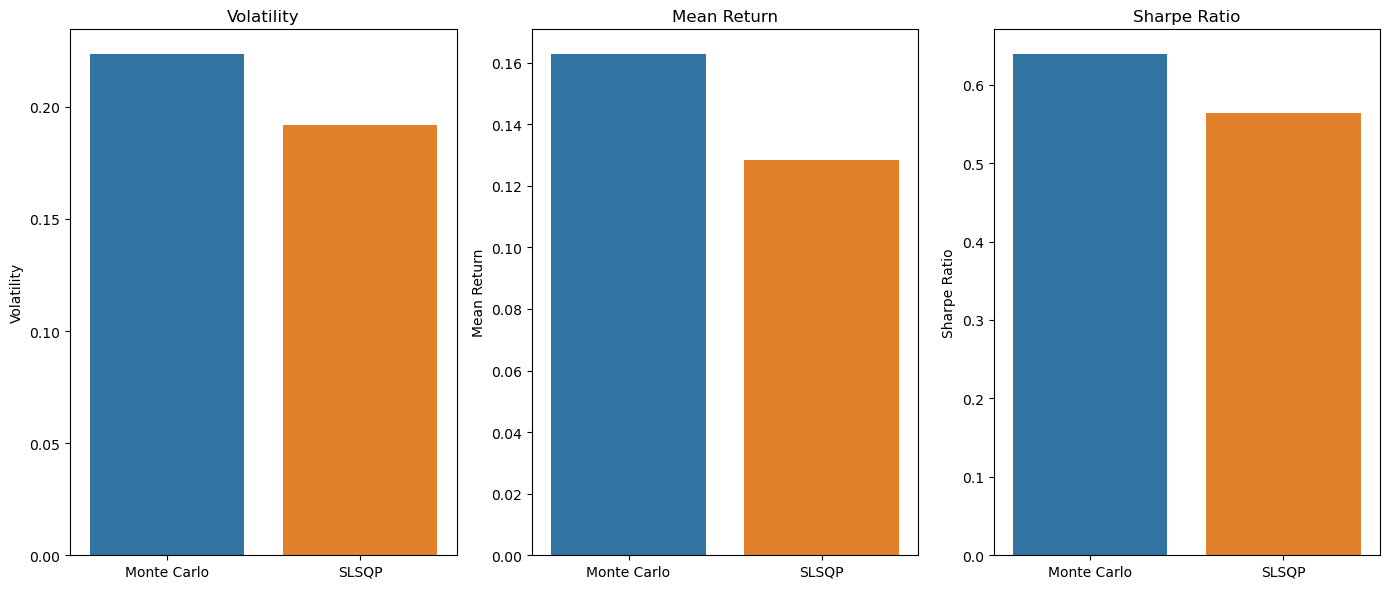

In [14]:
def calculate_portfolio_metrics(weights, data):
    returns = data.pct_change().dropna()
    portfolio_return = np.dot(returns.mean(), weights) * 252  # Annualized return
    portfolio_variance = np.dot(weights.T, np.dot(returns.cov() * 252, weights))
    portfolio_volatility = np.sqrt(portfolio_variance)
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return portfolio_volatility, portfolio_return, sharpe_ratio

# Convert mc_weights to a numpy array
mc_weights_array = np.array([mc_weights[ticker] for ticker in selected_tickers])

# Calculate metrics for Monte Carlo portfolio
mc_volatility, mc_return, mc_sharpe_ratio = calculate_portfolio_metrics(mc_weights_array, data)

# Calculate metrics for SLSQP portfolio
slsqp_volatility, slsqp_return, slsqp_sharpe_ratio = calculate_portfolio_metrics(slsqp_weights / 100, data)  # Convert percentage weights to fractions

# Print the metrics for both portfolios
print("Monte Carlo Portfolio Metrics:")
print(f"Volatility: {mc_volatility:.6f}")
print(f"Mean Return: {mc_return:.6f}")
print(f"Sharpe Ratio: {mc_sharpe_ratio:.6f}")

print("\nSLSQP Portfolio Metrics:")
print(f"Volatility: {slsqp_volatility:.6f}")
print(f"Mean Return: {slsqp_return:.6f}")
print(f"Sharpe Ratio: {slsqp_sharpe_ratio:.6f}")

# Compare and choose the better portfolio
if mc_volatility < slsqp_volatility:
    print("\nMonte Carlo Portfolio is better based on lower volatility.")
    better_portfolio = 'Monte Carlo'
elif slsqp_volatility < mc_volatility:
    print("\nSLSQP Portfolio is better based on lower volatility.")
    better_portfolio = 'SLSQP'
else:
    # If volatilities are similar, compare mean returns
    if mc_return > slsqp_return:
        print("\nVolatilities are similar. Monte Carlo Portfolio is better based on higher mean return.")
        better_portfolio = 'Monte Carlo'
    else:
        print("\nVolatilities are similar. SLSQP Portfolio is better based on higher mean return.")
        better_portfolio = 'SLSQP'

print(f"\nBetter Portfolio: {better_portfolio}")

# Visualizations
metrics = {
    "Monte Carlo": [mc_volatility, mc_return, mc_sharpe_ratio],
    "SLSQP": [slsqp_volatility, slsqp_return, slsqp_sharpe_ratio]
}

# Create a DataFrame for easy plotting
metrics_df = pd.DataFrame(metrics, index=["Volatility", "Mean Return", "Sharpe Ratio"])

# Plot the metrics
plt.figure(figsize=(14, 6))

# Subplot 1: Volatility
plt.subplot(1, 3, 1)
sns.barplot(x=metrics_df.columns, y=metrics_df.loc["Volatility"])
plt.title('Volatility')
plt.ylabel('Volatility')

# Subplot 2: Mean Return
plt.subplot(1, 3, 2)
sns.barplot(x=metrics_df.columns, y=metrics_df.loc["Mean Return"])
plt.title('Mean Return')
plt.ylabel('Mean Return')

# Subplot 3: Sharpe Ratio
plt.subplot(1, 3, 3)
sns.barplot(x=metrics_df.columns, y=metrics_df.loc["Sharpe Ratio"])
plt.title('Sharpe Ratio')
plt.ylabel('Sharpe Ratio')

plt.tight_layout()
plt.show()


### Creating Stocks_Final DataFrame and Exporting to CSV file

In [15]:
# Create the Stocks_Final DataFrame
if better_portfolio == 'Monte Carlo':
    Stocks_Final = Portfolio_Final[['Ticker', 'Shares']].copy()
else:
    Stocks_Final = Portfolio_Final2[['Ticker', 'Shares']].copy()


# Exporting Stocks_Final DataFrame to CSV file
Stocks_Final.to_csv('Stocks_Group_18.csv')